<a href="https://colab.research.google.com/github/juno-yuu/COVID-Vaccine-and-Biotech-industry/blob/Erin/Final_Project_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github

In [16]:
!git clone https://github.com/juno-yuu/COVID-Vaccine-and-Biotech-industry.git

fatal: destination path 'COVID-Vaccine-and-Biotech-industry' already exists and is not an empty directory.


### Imports

In [20]:
import warnings
warnings.filterwarnings('ignore')
import requests
import io
import pandas.util.testing as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### Read Datasets

In [62]:
# vaccination dataset
vacci = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/us_state_vaccinations.csv", index_col = 0)

# comfirmed
case_confirmed = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/time_series_covid19_confirmed_US.csv")

# death
case_death = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/time_series_covid19_deaths_US.csv")

# latest data
update = pd.read_csv("/content/COVID-Vaccine-and-Biotech-industry/05-26-2021_us.csv")

# manufacture daily
# download = requests.get('https://raw.githubusercontent.com/xinyanz-erin/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv').content
# manu = pd.read_csv(io.StringIO(download.decode('utf-8')))
manu = pd.read_csv("https://raw.githubusercontent.com/xinyanz-erin/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv", index_col = 1)

### Check datasets

In [63]:
vacci.head()

,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,
2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN


In [8]:
case_confirmed.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6760,6763,6763,6773,6793,6819,6835,6876,6879,6882,6889,6890,6897,6904,6907,6909,6910,6910,6914,6914,6918,6918,6920,6920,6926,6928,6938,6971,7001,7005,7010,7015,7017,7049,7106,7113,7118,7118,7126,7135
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20714,20723,20730,20764,20787,20815,20833,20838,20847,20863,20875,20897,20921,20941,20966,20983,20993,20993,21035,21093,21107,21123,21131,21135,21154,21170,21191,21290,21392,21411,21422,21444,21467,21489,21511,21535,21546,21554,21578,21593
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2271,2271,2271,2275,2284,2289,2292,2296,2296,2296,2297,2298,2299,2300,2302,2302,2302,2302,2307,2307,2307,2307,2308,2308,2310,2314,2317,2319,2320,2320,2320,2322,2324,2326,2327,2328,2328,2328,2331,2331
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2563,2563,2567,2569,2569,2573,2578,2582,2584,2584,2588,2591,2593,2594,2596,2596,2597,2597,2604,2604,2604,2605,2607,2607,2609,2612,2615,2630,2645,2647,2648,2651,2652,2656,2657,2656,2658,2659,2660,2662
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6529,6532,6532,6548,6556,6563,6570,6570,6571,6574,6581,6595,6607,6613,6616,6619,6621,6621,6635,6645,6651,6656,6660,6661,6678,6680,6694,6750,6771,6773,6776,6794,6808,6816,6826,6829,6832,6832,6847,6856


In [9]:
case_death.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,106,106,106,106,107,107,107,107,107,107,107,107,107,107,107,107,107,107,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,109,109,110,110,110,110,110
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,302,302,302,302,302,303,303,305,305,305,305,305,305,305,306,306,306,306,307,307,307,308,308,308,308,309,309,309,310,310,310,310,310,310,310,310,310,310,310,310
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,55,55,55,55,56,56,56,56,56,56,56,56,56,56,56,56,56,56,57,57,57,57,57,57,56,56,56,56,56,56,56,56,58,58,58,58,58,58,58
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,61,61,61,61,61,62,62,62,62,62,62,63,63,63,63,63,63,63,63,63,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,133,133,133,133,133,133,134,134,134,134,134,134,135,135,135,135,135,135,136,136,137,137,137,137,137,137,137,139,139,139,139,139,139,139,139,139,139,139,139,139


In [14]:
update.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2021-05-27 04:30:49,32.3182,-86.9023,542831,11138,NaN,NaN,1.0,11070.987532,2600239.0,NaN,2.051836,84000001.0,USA,53031.631480,NaN
1,Alaska,US,2021-05-27 04:30:49,61.3707,-152.4044,70119,369,NaN,NaN,2.0,9585.056285,2243112.0,NaN,0.526248,84000002.0,USA,306626.660014,NaN
2,American Samoa,US,2021-05-27 04:30:49,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN
3,Arizona,US,2021-05-27 04:30:49,33.7298,-111.4312,878338,17576,NaN,NaN,4.0,12067.209097,9614180.0,NaN,2.001052,84000004.0,USA,132086.190465,NaN
4,Arkansas,US,2021-05-27 04:30:49,34.9697,-92.3731,340698,5827,NaN,NaN,5.0,11289.599987,3041698.0,NaN,1.710312,84000005.0,USA,100791.767789,NaN


In [61]:
manu.head()

,location,vaccine,total_vaccinations
date,,,
2020-12-24,Chile,Pfizer/BioNTech,420
2020-12-25,Chile,Pfizer/BioNTech,5198
2020-12-26,Chile,Pfizer/BioNTech,8338
2020-12-27,Chile,Pfizer/BioNTech,8649
2020-12-28,Chile,Pfizer/BioNTech,8649


### Data Cleaning and Combining

In [90]:
manu.location.unique()
manu.vaccine.unique()

array(['Pfizer/BioNTech', 'Sinovac', 'Oxford/AstraZeneca', 'Moderna',
       'Johnson&Johnson'], dtype=object)

In [93]:
Pf_manu = manu.loc[manu.vaccine == 'Pfizer/BioNTech']
Pf_manu = Pf_manu.loc[Pf_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

Mod_manu = manu.loc[manu.vaccine == 'Moderna']
Mod_manu = Mod_manu.loc[Mod_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

JJ_manu = manu.loc[manu.vaccine == 'Johnson&Johnson']
JJ_manu = JJ_manu.loc[JJ_manu.location == 'United States', ['vaccine', 'total_vaccinations']]
print(Pf_manu.head())

                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             9281063
                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             9281063
                    vaccine  total_vaccinations
date                                           
2021-01-12  Pfizer/BioNTech             5488697
2021-01-13  Pfizer/BioNTech             6025872
2021-01-15  Pfizer/BioNTech             7153268
2021-01-19  Pfizer/BioNTech             8874811
2021-01-20  Pfizer/BioNTech             

In [104]:
# keep stats level data
vacci = vacci[vacci.location != 'United States']
vacci_us = vacci.groupby('date').sum()
vacci_us.head()

,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,
2021-01-12,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-14,12374484.0,35343775.0,10886077.0,0.00,209.66,0.0,178.06,624.62,1011845.0,1047786.0,176936.0,23.766
2021-01-15,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-16,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,947221.5,1083109.0,182231.0,0.000


In [105]:
Pf_manu_vacci = Pf_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
Pf_manu_vacci.head(10)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-01-12,Pfizer/BioNTech,5488697,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,Pfizer/BioNTech,6025872,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-15,Pfizer/BioNTech,7153268,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-19,Pfizer/BioNTech,8874811,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303
2021-01-20,Pfizer/BioNTech,9281063,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830
2021-01-21,Pfizer/BioNTech,9817027,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246
2021-01-22,Pfizer/BioNTech,10695066,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468
2021-01-23,Pfizer/BioNTech,11471457,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705
2021-01-24,Pfizer/BioNTech,12153536,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769


In [106]:
Mod_manu_vacci = Mod_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
Mod_manu_vacci.head(10)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-01-12,Moderna,3835859,10278912.0,32081325.0,8347766.0,14.16,174.26,784657.0,114.74,573.67,0.0,0.0,0.0,22.063
2021-01-13,Moderna,4249795,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508
2021-01-15,Moderna,5122662,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954
2021-01-19,Moderna,6828561,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303
2021-01-20,Moderna,7239750,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830
2021-01-21,Moderna,7724683,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246
2021-01-22,Moderna,8407909,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468
2021-01-23,Moderna,9061112,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705
2021-01-24,Moderna,9689497,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769


In [107]:
JJ_manu_vacci = JJ_manu.join(vacci_us, how = 'left', lsuffix = '_manu', rsuffix = '_vacci')
JJ_manu_vacci.head()

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
date,,,,,,,,,,,,,,
2021-03-08,Johnson&Johnson,208590,103758241.0,122473710.0,62549309.0,612.21,1767.85,32897443.0,1135.82,2398.49,1824650.0,2287671.0,377665.0,48.104
2021-03-09,Johnson&Johnson,308181,105467512.0,129540430.0,63678459.0,623.33,1794.28,33544611.0,1152.60,2507.32,1709271.0,2277293.0,384672.0,46.492
2021-03-10,Johnson&Johnson,458911,107614717.0,134410410.0,65089854.0,639.85,1836.32,34385505.0,1180.36,2583.54,2147205.0,2294866.0,400701.0,46.015
2021-03-11,Johnson&Johnson,638469,110233615.0,137798185.0,66767597.0,658.40,1881.51,35389429.0,1209.30,2644.55,2618898.0,2359359.0,410068.0,46.039
2021-03-12,Johnson&Johnson,873726,113299843.0,140121405.0,68719280.0,681.17,1937.86,36578051.0,1245.49,2681.15,3066228.0,2428889.0,422884.0,46.740


In [114]:
Pf_manu_vacci['daily_vaccinations_lagged'] = Pf_manu_vacci['daily_vaccinations'].shift(1) # get the lagged daily vaccinations data
Mod_manu_vacci['daily_vaccinations_lagged'] = Mod_manu_vacci['daily_vaccinations'].shift(1)
JJ_manu_vacci['daily_vaccinations_lagged'] = JJ_manu_vacci['daily_vaccinations'].shift(1)

In [119]:
ultimate = (Pf_manu_vacci.append(Mod_manu_vacci)).append(JJ_manu_vacci)
ultimate = ultimate.dropna()
ultimate.head(20)

,vaccine,total_vaccinations_manu,total_vaccinations_vacci,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,daily_vaccinations_lagged
date,,,,,,,,,,,,,,,
2021-01-13,Pfizer/BioNTech,6025872,11362639.0,33936700.0,9082123.0,18.95,193.37,1037160.0,126.40,610.84,1083727.0,1083727.0,191029.0,22.508,0.0
2021-01-15,Pfizer/BioNTech,7153268,13664143.0,31161075.0,10595866.0,31.93,231.50,1610524.0,198.42,650.16,1289659.0,1128409.0,190744.0,24.954,1083727.0
2021-01-19,Pfizer/BioNTech,8874811,17453029.0,31161075.0,13595803.0,39.95,294.24,2023124.0,252.75,650.16,947221.5,1024875.0,171345.0,31.303,1128409.0
2021-01-20,Pfizer/BioNTech,9281063,18433513.0,35990150.0,14270417.0,43.04,309.90,2161419.0,265.22,716.83,980484.0,1010126.0,166520.0,28.830,1024875.0
2021-01-21,Pfizer/BioNTech,9817027,19635555.0,37960000.0,15053257.0,48.18,330.89,2394961.0,281.05,748.19,1202042.0,1037298.0,173267.0,29.246,1010126.0
2021-01-22,Pfizer/BioNTech,10695066,21397243.0,39892400.0,16243093.0,55.35,359.79,2756953.0,302.55,774.72,1761688.0,1104734.0,183333.0,30.468,1037298.0
2021-01-23,Pfizer/BioNTech,11471457,22975660.0,41411550.0,17390345.0,59.93,384.49,3027865.0,322.48,795.34,1578417.0,1194901.0,196176.0,31.705,1104734.0
2021-01-24,Pfizer/BioNTech,12153536,24415673.0,41411550.0,18502131.0,63.41,410.77,3216836.0,345.12,795.34,1440013.0,1265296.0,211301.0,33.769,1194901.0
2021-01-25,Pfizer/BioNTech,12551999,25448730.0,41418325.0,19252279.0,65.48,424.17,3346390.0,356.37,801.87,1033057.0,1277560.0,208112.0,34.883,1265296.0


### Predictions

#### Panel Regression

<function matplotlib.pyplot.show>

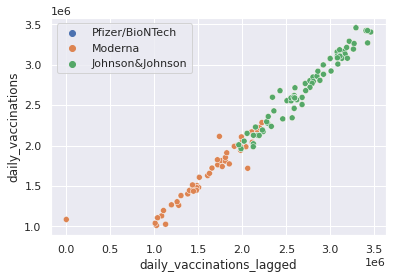

In [124]:
plt.figure()
ax = sns.scatterplot(x = 'daily_vaccinations_lagged', y = 'daily_vaccinations', data = ultimate, hue = 'vaccine', legend = 'brief')
plt.legend()
plt.show